In [1]:
import torch
import matplotlib.pyplot as plt
from prior.sobolgau import *
from kernel.rbf import *          # your PyTorch GPU kernel functions
from kmed import plainkmed as pk

In [2]:
import numpy as np

In [3]:
def normal_pdf(x, mu, sigma):
    coeff = 1 / (sigma * np.sqrt(2 * np.pi))
    exponent = -((x - mu) ** 2) / (2 * sigma ** 2)
    return coeff * np.exp(exponent)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def nll(X):
    return 0.5 * torch.sum(X**2, dim=0)

In [6]:
d = 1
N_step = 50
N = 500

In [7]:
mu_0 = 4.0 * torch.ones(d, device=device)
Sigma_0 = torch.eye(d, device=device)
X_0 = sobol_multivariate_normal(N, mu_0, Sigma_0)

In [8]:
dt = 1.0 / N_step
X_record = torch.zeros((N_step+1, d, N), device=device)
X_record[0,:,:] = X_0
for epoch in range(N_step):
    X = X_record[epoch,:,:]
    mu_x = X.mean(dim=1, keepdim=True)
    X_c = X - mu_x
    P = torch.einsum("im,jm->ij", X_c, X_c) / (N - 1)
    k, grad1k = kernel(X, use_median=True, alpha=4.0)
    h = nll(X)
    h_bar = torch.mean(h)
    H = h - h_bar

    v = pk.velocity(H, k, grad1k, P, d, N, reg=1e-9)
    X_record[epoch+1,:,:] = X + v * dt
    if (epoch+1)%10 == 0:
        print("Step - " + str (epoch+1) + " has been complete!")

Step - 10 has been complete!
Step - 20 has been complete!
Step - 30 has been complete!
Step - 40 has been complete!
Step - 50 has been complete!


In [9]:
X_r = np.array(X_record.cpu())

C:\Users\linfe\AppData\Local\Temp\ipykernel_22888\734206017.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_r = np.array(X_record.cpu())


In [10]:
xx = np.linspace(-1,8,2000)

In [11]:
yy_prior = normal_pdf(xx, 4.0, 1.0)

In [12]:
yy_post = normal_pdf(xx, 2.0, np.sqrt(0.5))

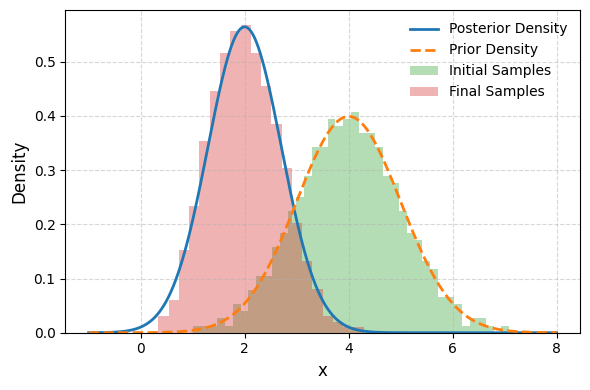

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

# Plot true densities
ax.plot(xx, yy_post, label='Posterior Density', linewidth=2)
ax.plot(xx, yy_prior, label='Prior Density', linewidth=2, linestyle='--')

# Plot histograms of samples
ax.hist(X_r[0, 0, :], bins=40, density=True, alpha=0.35, 
        label='Initial Samples')
ax.hist(X_r[-1, 0, :], bins=20, density=True, alpha=0.35, 
        label='Final Samples')

# Axes labels
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(frameon=False, fontsize=10)

# Tight layout for publication
plt.tight_layout()
plt.savefig("Plots/Toy/Gauhist.png")
plt.show()


In [14]:
mu = 4.0 
def mean_var_t(t):
    mt = mu / (1 + t)
    vt = 1.0 / (1 + t)
    return mt, vt

def He1_expectation(t):
    mt, vt = mean_var_t(t)
    return mt

def He2_expectation(t):
    mt, vt = mean_var_t(t)
    return mt**2 + vt - 1

def He3_expectation(t):
    mt, vt = mean_var_t(t)
    return mt**3 + 3*mt*vt - 3*mt

def He4_expectation(t):
    mt, vt = mean_var_t(t)
    return (
        mt**4 + 6*mt**2*vt + 3*vt**2
        - 6*(mt**2 + vt)
        + 3
    )


In [15]:
tt = np.linspace(0,1,N_step+1)

In [16]:
T_1 = He1_expectation(tt)
T_2 = He2_expectation(tt)
T_3 = He3_expectation(tt)
T_4 = He4_expectation(tt)
O_true = [T_1, T_2, T_3, T_4]

In [17]:
X_r_1 = X_r
X_r_2 = X_r ** 2 - 1.0
X_r_3 = X_r ** 3 - 3.0 * X_r
X_r_4 = X_r ** 4 - 6.0 * X_r ** 2 + 3.0
T_1_est = np.mean(X_r_1, axis = 2)[:,0]
T_2_est = np.mean(X_r_2, axis = 2)[:,0]
T_3_est = np.mean(X_r_3, axis = 2)[:,0]
T_4_est = np.mean(X_r_4, axis = 2)[:,0]
T_1_est_err = np.std(X_r_1, axis = 2)[:,0]
T_2_est_err = np.std(X_r_2, axis = 2)[:,0]
T_3_est_err = np.std(X_r_3, axis = 2)[:,0]
T_4_est_err = np.std(X_r_4, axis = 2)[:,0]
O_est = [T_1_est, T_2_est, T_3_est, T_4_est]
O_err = [T_1_est_err, T_2_est_err, T_3_est_err, T_4_est_err]

In [18]:
T_1

array([4.        , 3.92156863, 3.84615385, 3.77358491, 3.7037037 ,
       3.63636364, 3.57142857, 3.50877193, 3.44827586, 3.38983051,
       3.33333333, 3.27868852, 3.22580645, 3.17460317, 3.125     ,
       3.07692308, 3.03030303, 2.98507463, 2.94117647, 2.89855072,
       2.85714286, 2.81690141, 2.77777778, 2.73972603, 2.7027027 ,
       2.66666667, 2.63157895, 2.5974026 , 2.56410256, 2.53164557,
       2.5       , 2.4691358 , 2.43902439, 2.40963855, 2.38095238,
       2.35294118, 2.3255814 , 2.29885057, 2.27272727, 2.24719101,
       2.22222222, 2.1978022 , 2.17391304, 2.15053763, 2.12765957,
       2.10526316, 2.08333333, 2.06185567, 2.04081633, 2.02020202,
       2.        ])

In [23]:
def plot_merged_hp(truth_dict, est_dict, tt, save_path, eps=1e-12):

    orders = sorted(truth_dict.keys())
    colors = plt.cm.tab10(np.linspace(0, 1, len(orders)))
    markers = ["o", "s", "D", "^", "v", "P", "X"]

    fig, ax = plt.subplots(figsize=(6.2, 4.0))

    for i, n in enumerate(orders):
        c = colors[i]
        marker = markers[i % len(markers)]

        truth = np.asarray(truth_dict[n])
        est   = np.asarray(est_dict[n])

        # --- Normalization (for plotting only) ---
        max_val = np.max(np.abs(truth))
        truth_norm = truth / (max_val + eps)
        est_norm   = est   / (max_val + eps)

        truth_scaled = n * truth_norm
        est_scaled   = n * est_norm

        # --- Time-averaged relative error (pointwise then mean) ---
        rel_err_t = np.abs(est - truth) / (np.abs(truth) + eps)
        rel_err   = np.mean(rel_err_t)

        # --- Plot truth ---
        ax.plot(
            tt, truth_scaled,
            color=c,
            linewidth=2.2,
            label=f"Truth (n={n})"
        )

        # --- Plot estimate with error in legend ---
        ax.scatter(
            tt, est_scaled,
            color=c,
            edgecolor="black",
            s=28,
            marker=marker,
            linewidth=0.4,
            label=rf"Estimate (n={n}), $\overline{{\varepsilon}}_{{{n}}}={rel_err:.2e}$"
        )

    ax.set_xlabel(r"$t$", fontsize=12)
    ax.set_ylabel("Scaled Observable", fontsize=12)

    ax.grid(True, linestyle="--", alpha=0.4)
    ax.tick_params(labelsize=10)

    ax.legend(
        frameon=False,
        fontsize=9,
        ncol=1,
        handlelength=2
    )

    fig.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


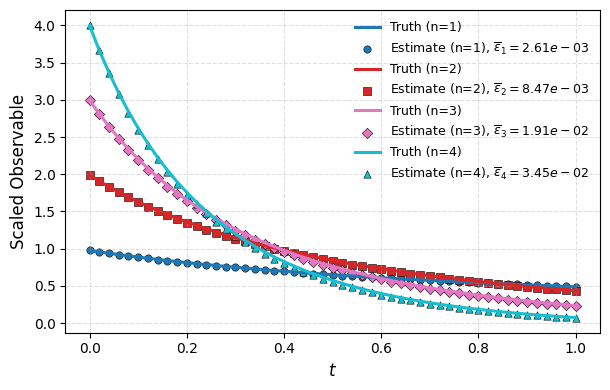

In [25]:
truth_dict = {
    1: T_1,
    2: T_2,
    3: T_3,
    4: T_4,
}

est_dict = {
    1: T_1_est,
    2: T_2_est,
    3: T_3_est,
    4: T_4_est,
}
save_path = "Plots/Toy/GauHe.png"
plot_merged_hp(truth_dict, est_dict, tt, save_path, eps = 0.1)
